# <b> <center> <font color='blue'> SALARY PREDICTION </font> </color> </b>

## Table of Contents

1. [Problem Statement](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Data Loading, Exploration and Pre-processing](#4)
5. [Build, compile and train the model](#5)
6. [Making predictions](#6)

<a name="1"></a>
## <b> <font color='#21618C'> 1. Problem Statement </font> </color>

We are going to predict the salary using several features.

<a name="2"></a>
## <b> <font color='#21618C'> 2. Modules </font> </color>

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import warnings
warnings.filterwarnings('ignore')

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

<a name="3"></a>
## <b> <font color='#21618C'> 3. Helper Functions </font> </color>

In [46]:
# plotting utilities

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    axs[0].set_title('MAE',fontsize=14, fontweight='bold',color='red')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Mean Abs Error [MPG]')
    axs[0].plot(hist['epoch'], hist['mae'],
           label='Train Error')
    axs[0].plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    axs[0].legend()


    axs[1].set_title('MSE',fontsize=14, fontweight='bold',color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Mean Square Error [$MPG^2$]')
    axs[1].plot(hist['epoch'], hist['mse'],
           label='Train Error')
    axs[1].plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    axs[1].legend()

<a name="3"></a>
## <b> <font color='#21618C'> 3. Data Loading, Exploration and Pre-processing </font> </color>

### Loading data and exploring

In [18]:
df = pd.read_csv('data/Salary Data.csv')

df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [19]:
df.columns

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')

### Pre-processing

Drop nan values

In [20]:
df.isna().sum()

Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

In [21]:
df.dropna(inplace=True)

In [22]:
# check
df.isna().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

Separate into features and label

In [23]:
# Extract features (input variables)
X = df.drop('Salary', axis=1)  # Exclude the column representing the target variable

# Extract label (target variable)
y = df['Salary']  # Select the column representing the target variable

type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

We are going to:

- Normalize numerical columns
- One-hot encoding categorical values 

In [24]:
# numerical variables
features_num = [
    "Age","Years of Experience",
]

# categorical variables
features_cat = [
    "Gender","Education Level","Job Title"
]

In [29]:
# for numerical variables
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)


# for categorical variables
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore',sparse=False), # sparse it's fundamental!! if we do not use it
    # we're gonna have type problems later with tensorflow
)

# preprocessor
preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [30]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size=0.75)

X_train = preprocessor.fit_transform(X_train) # fit and transform
X_test = preprocessor.transform(X_test) # only transform

input_shape = [X_train.shape[1]]


type(X_train), type(y_train), input_shape, X_train.shape

(numpy.ndarray, pandas.core.series.Series, [154], (279, 154))

<a name="4"></a>
## <b> <font color='#21618C'> 4. Build, compile and train our model </font> </color>

In [86]:
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128,input_shape=input_shape),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(64),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [87]:
model = build_model(input_shape)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 128)               19840     
                                                                 
 dense_55 (Dense)            (None, 128)               16512     
                                                                 
 dense_56 (Dense)            (None, 128)               16512     
                                                                 
 dense_57 (Dense)            (None, 64)                8256      
                                                                 
 dense_58 (Dense)            (None, 1)                 65        
                                                                 
Total params: 61185 (239.00 KB)
Trainable params: 61185 (239.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
# Early Stopping Callback
callbacks = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit(
        X_train,y_train,
        validation_split=0.2,
        epochs=100,
        verbose=0,
        callbacks=callbacks,
)

Epoch 89: early stopping


<a name="5"></a>
## <b> <font color='#21618C'> 5. Model Evaluation </font> </color>

In [89]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 0s 3ms/step - loss: 294455936.0000 - mae: 11093.3174 - mse: 294455936.0000


[294455936.0, 11093.3173828125, 294455936.0]

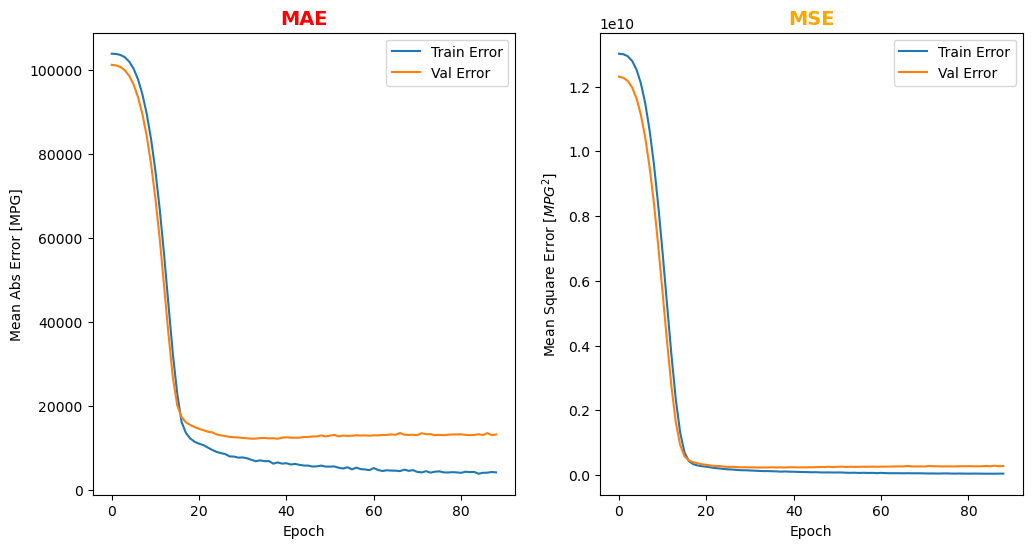

In [90]:
plot_history(history)

<a name="4"></a>
## <b> <font color='#21618C'> 4. Making predictions </font> </color>

In [68]:
# data
data = {
    "Years of Experience": [3.0],
    "Gender": ["Male"],
    "Education Level": ["PhD"],
    "Job Title": ["Data Analyst"],
    "Age": [32.0]
}

# Create the DataFrame
df = pd.DataFrame(data)

# apply transformations
input_transformed = preprocessor.transform(df)

# prediction
prediction = model.predict(input_transformed)
prediction


1/1 [==============================] - 0s 67ms/step


array([[50499.477]], dtype=float32)